In [1]:
import matplotlib.pyplot as plt
import datetime
import tilemapbase as tmb
from pathlib import Path
import numpy as np

from pluma.preprocessing.resampling import resample_temporospatial
from pluma.preprocessing.ecg import heartrate_from_ecg
from pluma.export.ogcapi.features import export_geoframe_to_geojson
from pluma.export.ogcapi.records import DatasetRecord, RecordProperties, Contact
from pluma.stream.georeference import Georeference
from pluma.stream.ubx import _UBX_MSGIDS
from pluma.schema import Dataset
from FmulSchema import custom_schema
from helpers import *

## Notebook plotting
%matplotlib inline
plt.style.use('ggplot')

## Figure export parameters
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
import matplotlib as mpl
mpl.rcParams.update(new_rc_params)


# Set the paths to the dataset and build the dataset

c:\Users\gonca\Projects\github\emotional-cities\notebooks\.conda\lib\site-packages\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\gonca\NeuroGEARS Ltd\Emotional Cities - Documents\Experiment Control and Acquisition\Datasets\Lansing\DownTownNatural\Lansing_DownTownNatural_sub-OE825001_2023-09-08T173218Z\Streams_33 could not be found.
  warnings.warn(f'Harp stream file\
c:\Users\gonca\Projects\github\emotional-cities\notebooks\.conda\lib\site-packages\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\gonca\NeuroGEARS Ltd\Emotional Cities - Documents\Experiment Control and Acquisition\Datasets\Lansing\DownTownNatural\Lansing_DownTownNatural_sub-OE825001_2023-09-08T173218Z\Streams_227 could not be found.
  warnings.warn(f'Harp stream file\
c:\Users\gonca\Projects\github\emotional-cities\notebooks\.conda\lib\site-packages\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\gonca\NeuroGEARS Ltd\E

@(WIN) --> C:\Users\gonca\NeuroGEARS Ltd\Emotional Cities - Documents\Experiment Control and Acquisition\Datasets\Lansing\DownTownNatural\Lansing_DownTownNatural_sub-OE825001_2023-09-08T173218Z\20230908183404_BenchmarkPupil.nedf
Reading file...
Header information has been correctly retrieved.
Attempting to automatically correct eeg timestamps to harp timestamps...
Done.


c:\Users\gonca\Projects\github\emotional-cities\notebooks\.conda\lib\site-packages\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\gonca\NeuroGEARS Ltd\Emotional Cities - Documents\Experiment Control and Acquisition\Datasets\Lansing\DownTownNatural\Lansing_DownTownNatural_sub-OE825001_2023-09-08T173218Z\Streams_211 could not be found.
  warnings.warn(f'Harp stream file\
c:\Users\gonca\Projects\github\emotional-cities\notebooks\.conda\lib\site-packages\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\gonca\NeuroGEARS Ltd\Emotional Cities - Documents\Experiment Control and Acquisition\Datasets\Lansing\DownTownNatural\Lansing_DownTownNatural_sub-OE825001_2023-09-08T173218Z\Streams_212 could not be found.
  warnings.warn(f'Harp stream file\
c:\Users\gonca\Projects\github\emotional-cities\notebooks\.conda\lib\site-packages\pluma\io\harp.py:44: UserWarning: Harp stream file            @(WIN) --> C:\Users\gonca\NeuroGEARS Ltd\

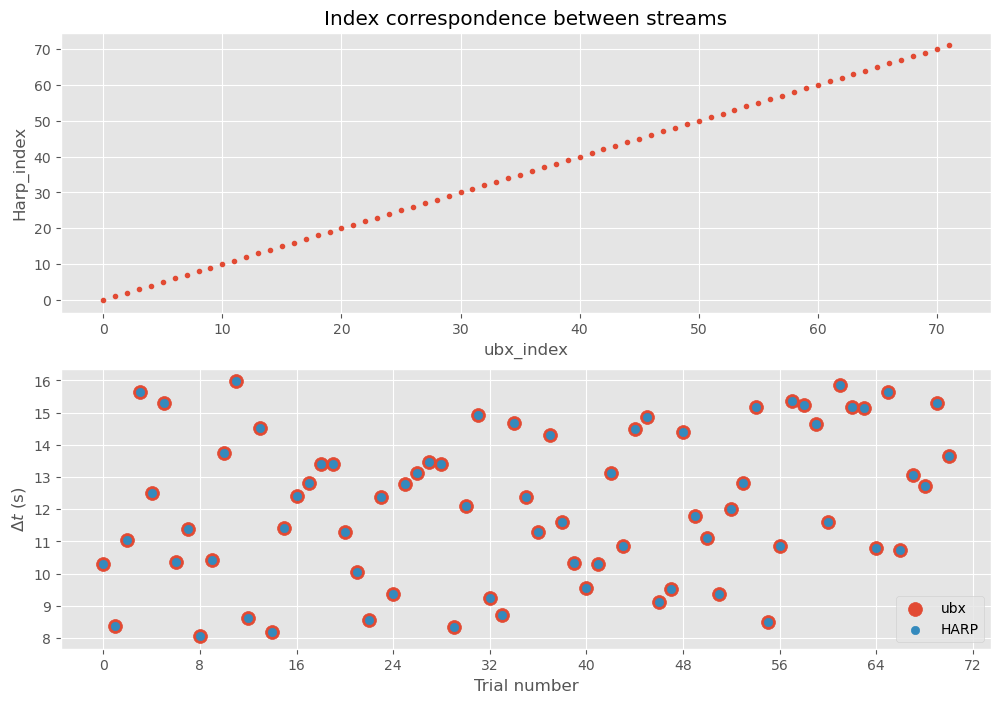

Dataset: <pluma.schema.Dataset object at 0x000001EE94ED4880> loaded successfully, and sucessfully calibrated.


In [2]:
# Path to the dataset. Can be local or remote.
dataset_root = r"C:\Users\gonca\NeuroGEARS Ltd\Emotional Cities - Documents\Experiment Control and Acquisition\Datasets"
# root = r"\Lansing\DownTownUrban\Lansing_DownTownUrban_sub-OE822001_2023-09-08T141128Z"
root = r"\Lansing\DownTownNatural\Lansing_DownTownNatural_sub-OE825001_2023-09-08T173218Z"

dataset = load_dataset(f"{dataset_root}{root}", schema=custom_schema)
print(f"Dataset: {dataset} loaded successfully, and {'not' if not dataset.has_calibration else 'sucessfully'} calibrated." )

## Export to SDI geoframe

In [3]:
gdf = dataset.to_geoframe(rereference_to_ubx_time=True)

Failed Stream Harp stream from device 		TK, stream GPS_Latitude(227): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Longitude(228): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Altitude(229): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_HasFix(232): Input dataframe is empty.
Failed Stream EEG stream from device Enobio, stream EEG: resample() takes 1 positional argument but 2 were given


## Dataset structure
The Dataset class follows the following structure:
```
Dataset/
├─ rootfolder
├─ datasetlabel
├─ streams/
├─ georeference/
```

 - `rootfolder` and `datasetlabel` are properties that store the location and label of the dataset, respectively.
 - `streams` is a `DotMap` structure with the initialized schema and, if loaded, all the data. The data of each stream can be generally accessed using `dataset.Stream.data`. Additionally, the Streams can be easily navigated using the "." (dot) notation to access different, potentially nested, relevant fields.
 - `georeference` stores the DataFrame necessary to "geotag" sensor data (*i.e.* to cross-reference in time)

In [ ]:
# For simplicity a general method can be used to attempt to plot the data inside a stream:
plot_stream(dataset.streams.TK.AirQuality.IAQIndex)

## Visualization:

We are not in a position where we can visualize data in both time and space. The following cells will demo this affordance.

In [4]:
# The first time you run tilemapbase library, you will need to initiate a cache structure
# Initialize tilemapbase cache (run this only once)
if True:
    import tilemapbase as tmb
    tmb.init(create=True)
plot_kwargs = {
    'markersize': 5,
    'to_aspect': (4/30),
    'figsize': (10,10),
    'tiles': tmb.tiles.build_OSM()
}

c:\Users\gonca\Projects\github\emotional-cities\notebooks\src\poc-v1\Benchmarks\FmulDataset\helpers.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


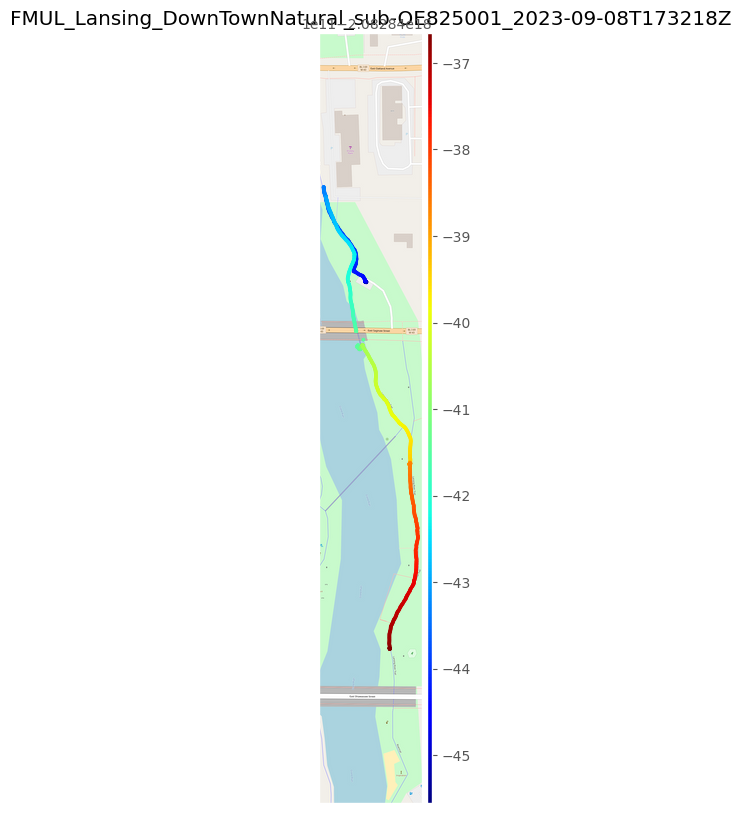

In [5]:
# First we will plot the spatial data colorcoded by time
plot_path(dataset, **plot_kwargs)

In [6]:
# plot resampled data in time and space using a dataset georeference. By default, it resamples the data to 2s bins
resampled = resample_temporospatial(dataset.streams.TK.AirQuality.IAQIndex.data, dataset.georeference)
plot_geospatial(resampled, **plot_kwargs, title='Air Quality Index')

NameError: name 'resample_temporospatial' is not defined

c:\Users\gonca\Projects\github\emotional-cities\notebooks\.conda\lib\site-packages\pluma\export\maps.py:50: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  im = ax.scatter(
c:\Users\gonca\Projects\github\emotional-cities\notebooks\src\poc-v1\Benchmarks\FmulDataset\helpers.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\gonca\Projects\github\emotional-cities\notebooks\src\poc-v1\Benchmarks\FmulDataset\helpers.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


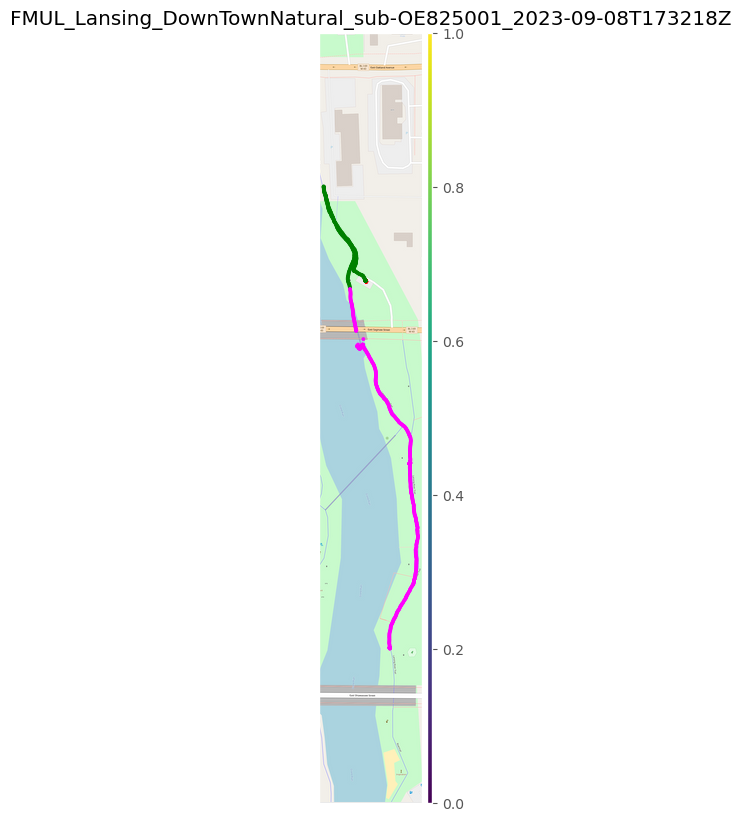

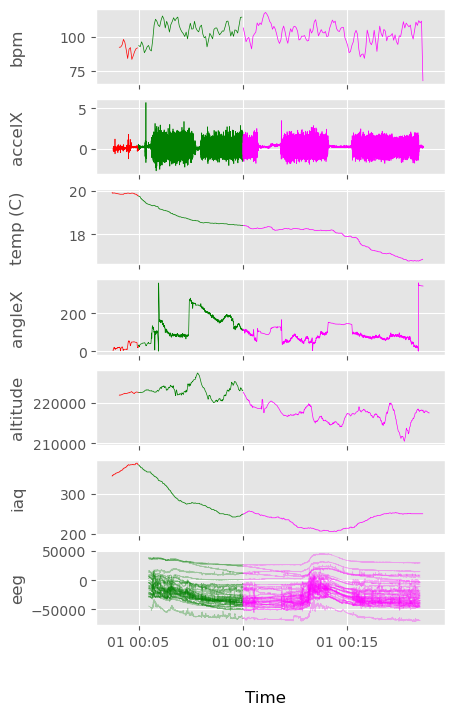

In [14]:
# Sometimes additional preprocessing might be required. As an example, when calculating heart rate from the ECG raw signal.
from pluma.preprocessing.ecg import heartrate_from_ecg

hr,_ = heartrate_from_ecg(dataset.streams.BioData.ECG,
                                         fs = 250, max_heartrate_bpm = 250.0,
                                        peak_height = 800, smooth_win = 10) ## Calculates HR from ecg raw signal
resampled = resample_temporospatial(hr, dataset.georeference,
                                    sampling_dt = datetime.timedelta(seconds = 4)) #Resample

segment_colors = np.array(['red', 'green', 'magenta', 'black', 'blue'])
hr_kwargs = { **plot_kwargs, 'cmap': 'brg', 'markersize': 10 }

# marker_segments = eeg_segments(dataset)
marker_segments = periodic_segments(dataset).iloc[:-1]

path_segments = marker_segments.reindex(dataset.georeference.elevation.index, method='pad')
plot_path(dataset, colorscale_override=segment_colors[path_segments.MarkerIdx], **plot_kwargs)

segments = [(x, segment_colors[idx % len(segment_colors)])
            for (x, idx) in marker_segments.reset_index().values]

traces = {
    'bpm': resampled.Data,
    'accelX': dataset.streams.Accelerometer.data["Accl_X"],
    'temp (C)': dataset.streams.TK.AirQuality.Temperature.data/100,
    'angleX': dataset.streams.Accelerometer.data["Orientation_X"],
    'altitude': dataset.georeference.elevation,
    'iaq': dataset.streams.TK.AirQuality.IAQIndex.data,
    'eeg': dataset.streams.EEG.data
}

plot_traces(traces, segments, figsize=(4.5,8))

In [ ]:
# Raw EEG traces
plt.figure(figsize=(15,6))
eeg_data = dataset.streams.EEG.data
plt.plot(eeg_data.np_time, eeg_data.np_eeg, lw = 0.5)
plt.show()

In [ ]:
# load and reindex pupil gaze data
gaze = load_pupilgaze(dataset)
vgaze = reindex_pupilgaze(dataset, gaze)
video = load_pupilvideo(dataset)
vgaze

In [ ]:
## Comparison of HR given by Empatica and raw ECG signal:
plt.figure(figsize=(15,6))
plt.plot(hr, label = 'ECG')
plt.plot(dataset.streams.Empatica.data.E4_Hr['Value'], label = 'Empatica')
plt.xlabel("Time")
plt.ylabel("HR(bpm)")
plt.legend()
plt.show()

In [ ]:
dataset.streams.Empatica.data.R

In [ ]:
## Export streams to csv
dataset.streams.TK.AirQuality.Temperature.export_to_csv("root")
